# Predicitve Analysis

## Derive features from raw dataset

In [37]:
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
from h3 import h3
import matplotlib.gridspec as gridspec
from matplotlib.ticker import StrMethodFormatter

In [4]:
raw_df = pd.read_csv("../train.csv")

In [5]:
raw_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
raw_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [7]:
feature_df = raw_df

In [8]:
# Change data types of columns
feature_df['pickup_datetime']= pd.to_datetime(feature_df['pickup_datetime']) 
feature_df['dropoff_datetime']= pd.to_datetime(feature_df['dropoff_datetime']) 

In [9]:
feature_df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

### Adding pickup dayOfweek,hour and minute

1. dayOfWeek - (0-6)

0 - Monday
1 - Tuesday
2 - Wednesday
3 - Thursday
4 - Friday
5 - Saturday
6 - Sunday

2. hour - (0-23)
3. minute - (1-59)

In [10]:
feature_df['dayOfWeek'] = feature_df['pickup_datetime'].dt.dayofweek
feature_df['hour'] = feature_df['pickup_datetime'].dt.hour
feature_df['minute'] = feature_df['pickup_datetime'].dt.minute

In [11]:
feature_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayOfWeek,hour,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,30


### Adding OSRM distance and duration

In [15]:
#call osrm api to get distance and duration
def call_OSRM(Picklon, Picklat, Droplon, Droplat):

    URL = "http://localhost:5000/route/v1/driving/{0},{1};{2},{3}".format(Picklon,Picklat,Droplon,Droplat)
    r = requests.get(URL)
    data = r.json()
    try:
        dis = data['routes'][0]['distance']
        dur = data['routes'][0]['duration']
    except:
        return "No_route","No_route"

    return dis,dur


#add osrm duration and distance to dataframe

def add_OSRM_dis_dur(data_frame): 
        df2 = data_frame
        
        try:
            df2['osrm_distance'],df2['osrm_duration'] = zip(*df2.apply(
                lambda row: call_OSRM(
                   Picklon = row['pickup_longitude'],
                   Picklat = row['pickup_latitude'],
                   Droplon = row['dropoff_longitude'],
                   Droplat = row['dropoff_latitude']

                ),
                axis = 1
            ))
        except Exception as e:
            print(e)
            pass
        return df2

In [18]:
add_OSRM_dis_dur(feature_df)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayOfWeek,hour,minute,osrm_distance,osrm_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,24,2009.7,165.5
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,43,2513.1,332.3
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,35,11060.5,773.3
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,32,1779.4,233.8
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,30,1615.1,172.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,4,13,31,2237.3,311.3
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6,7,35,7637.6,588.9
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,4,6,57,10172.9,630
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,1,15,56,1236,116.2


In [19]:
feature_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayOfWeek,hour,minute,osrm_distance,osrm_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,24,2009.7,165.5
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,43,2513.1,332.3
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,35,11060.5,773.3
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,32,1779.4,233.8
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,30,1615.1,172.2


In [21]:
feature_df.to_csv("feature_set_with_osrm_dis_dur.csv",index = False)

In [3]:
feature_df = pd.read_csv("feature_set_with_osrm_dis_dur.csv")

/home/dinesh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###  Adding H3 region center location

In [4]:
def get_h3ID(pick_lat, pick_lon, drop_lat, drop_lon, res_pick, res_drop):

        pick_ID = h3.geo_to_h3(pick_lat, pick_lon, res_pick)
        drop_ID = h3.geo_to_h3(drop_lat, drop_lon, res_drop)

        return pick_ID,drop_ID
    
def add_pick_drop_loc_ID(data_frame, res_pick, res_drop):

    df2 = data_frame
    try:
        df2['pick_hex_id'],df2['drop_hex_id'] = zip(*df2.apply(
            lambda row: get_h3ID(
                  pick_lat = row['pickup_latitude'],
                  pick_lon = row['pickup_longitude'],
                  drop_lat = row['dropoff_latitude'],
                  drop_lon = row['dropoff_longitude'],
                  res_pick = res_pick,
                  res_drop = res_drop

                ),
                axis = 1
            ))
    except Exception as e:
            print(e)
            pass

def get_centerloc(pick_cell_ID, drop_cell_ID):

    pick_lat,pick_lon = h3.h3_to_geo(pick_cell_ID)
    drop_lat,drop_lon = h3.h3_to_geo(drop_cell_ID)

    return  pick_lat, pick_lon, drop_lat, drop_lon

def add_centr_lat_lon(dataframe):
    df2 = dataframe
    try:
            df2['pick_hex_centr_lat'], df2['pick_hex_centr_lon'], df2['drop_hex_centr_lat'], df2['drop_hex_centr_lon'] = zip(*df2.apply(
                lambda row: get_centerloc(
                   pick_cell_ID = row['pick_hex_id'],
                   drop_cell_ID = row['drop_hex_id']

                ),
                axis = 1
            ))
    except Exception as e:
            print(e)
            pass
    return df2    

In [5]:
add_pick_drop_loc_ID(feature_df ,res_pick=8,res_drop=8)

In [6]:
add_centr_lat_lon(feature_df)

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,hour,minute,osrm_distance,osrm_duration,pick_hex_id,drop_hex_id,pick_hex_centr_lat,pick_hex_centr_lon,drop_hex_centr_lat,drop_hex_centr_lon
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,...,17,24,2009.7,165.5,882a1008b3fffff,882a100d69fffff,40.771055,-73.986556,40.766348,-73.964962
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,...,0,43,2513.1,332.3,882a100d2bfffff,882a1072cdfffff,40.739591,-73.976764,40.730917,-74.004238
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,...,11,35,11060.5,773.3,882a100d65fffff,882a107289fffff,40.763188,-73.984107,40.709680,-74.007674
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,...,19,32,1779.4,233.8,882a1072c7fffff,882a107281fffff,40.717542,-74.010125,40.704168,-74.016008
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,...,13,30,1615.1,172.2,882a100883fffff,882a100895fffff,40.789953,-73.972303,40.782084,-73.969855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,...,13,31,2237.3,311.3,882a100d29fffff,882a100d27fffff,40.747456,-73.979211,40.736430,-73.995897
1458640,1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,...,7,35,7637.6,588.9,882a100d25fffff,882a100881fffff,40.744295,-73.998347,40.797823,-73.974752
1458641,1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,...,6,57,10172.9,630,882a100893fffff,882a107289fffff,40.771860,-73.956611,40.709680,-74.007674
1458642,1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,...,15,56,1236,116.2,882a100d29fffff,882a100d61fffff,40.747456,-73.979211,40.760835,-73.973311


In [7]:
feature_df.to_csv("final_feature_set.csv", index = False)

In [1]:
import pandas as pd

In [2]:
feature_df = pd.read_csv("final_feature_set.csv")

/home/dinesh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
feature_df.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,hour,minute,osrm_distance,osrm_duration,pick_hex_id,drop_hex_id,pick_hex_centr_lat,pick_hex_centr_lon,drop_hex_centr_lat,drop_hex_centr_lon
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,...,17,24,2009.7,165.5,882a1008b3fffff,882a100d69fffff,40.771055,-73.986556,40.766348,-73.964962
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,...,0,43,2513.1,332.3,882a100d2bfffff,882a1072cdfffff,40.739591,-73.976764,40.730917,-74.004238
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,...,11,35,11060.5,773.3,882a100d65fffff,882a107289fffff,40.763188,-73.984107,40.709680,-74.007674
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,...,19,32,1779.4,233.8,882a1072c7fffff,882a107281fffff,40.717542,-74.010125,40.704168,-74.016008
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,...,13,30,1615.1,172.2,882a100883fffff,882a100895fffff,40.789953,-73.972303,40.782084,-73.969855


In [4]:
feature_df.dtypes

Unnamed: 0              int64
id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dayOfWeek               int64
hour                    int64
minute                  int64
osrm_distance          object
osrm_duration          object
pick_hex_id            object
drop_hex_id            object
pick_hex_centr_lat    float64
pick_hex_centr_lon    float64
drop_hex_centr_lat    float64
drop_hex_centr_lon    float64
dtype: object

In [5]:
df = feature_df[['id','passenger_count','store_and_fwd_flag','dayOfWeek','hour','minute','pick_hex_id','drop_hex_id','pick_hex_centr_lat','pick_hex_centr_lon','drop_hex_centr_lat','drop_hex_centr_lon','osrm_distance','osrm_duration','trip_duration']]

In [11]:
df.head()

,id,passenger_count,store_and_fwd_flag,pickup_day_of_week,pickup_hour,pickup_minute,pick_hex_id,drop_hex_id,pick_hex_centr_lat,pick_hex_centr_lon,drop_hex_centr_lat,drop_hex_centr_lon,osrm_distance,osrm_duration,trip_duration
0,id2875421,1,N,0,17,24,882a1008b3fffff,882a100d69fffff,40.771055,-73.986556,40.766348,-73.964962,2009.7,165.5,455
1,id2377394,1,N,6,0,43,882a100d2bfffff,882a1072cdfffff,40.739591,-73.976764,40.730917,-74.004238,2513.1,332.3,663
2,id3858529,1,N,1,11,35,882a100d65fffff,882a107289fffff,40.763188,-73.984107,40.709680,-74.007674,11060.5,773.3,2124
3,id3504673,1,N,2,19,32,882a1072c7fffff,882a107281fffff,40.717542,-74.010125,40.704168,-74.016008,1779.4,233.8,429
4,id2181028,1,N,5,13,30,882a100883fffff,882a100895fffff,40.789953,-73.972303,40.782084,-73.969855,1615.1,172.2,435


In [10]:
df.rename(columns={"pickupDayOfWeek":"pickup_day_of_week", "hour":"pickup_hour", "minute":"pickup_minute"},inplace=True)

/home/dinesh/.local/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
df = df.drop(df[df.osrm_distance=="No_route"].index)

In [14]:
feature_df.shape[0]

1458644

In [13]:
df.shape[0]

1458630

In [16]:
df.dtypes

id                     object
passenger_count         int64
store_and_fwd_flag     object
pickup_day_of_week      int64
pickup_hour             int64
pickup_minute           int64
pick_hex_id            object
drop_hex_id            object
pick_hex_centr_lat    float64
pick_hex_centr_lon    float64
drop_hex_centr_lat    float64
drop_hex_centr_lon    float64
osrm_distance          object
osrm_duration          object
trip_duration           int64
dtype: object

In [19]:
df['osrm_distance'] = pd.to_numeric(df['osrm_distance'])

In [20]:
df['osrm_duration'] = pd.to_numeric(df['osrm_duration'])

### Adding average velocity

In [21]:
df["average_velocity"] = df['osrm_distance']/df['trip_duration']

In [22]:
df.head()

,id,passenger_count,store_and_fwd_flag,pickup_day_of_week,pickup_hour,pickup_minute,pick_hex_id,drop_hex_id,pick_hex_centr_lat,pick_hex_centr_lon,drop_hex_centr_lat,drop_hex_centr_lon,osrm_distance,osrm_duration,trip_duration,average_velocity
0,id2875421,1,N,0,17,24,882a1008b3fffff,882a100d69fffff,40.771055,-73.986556,40.766348,-73.964962,2009.7,165.5,455,4.416923
1,id2377394,1,N,6,0,43,882a100d2bfffff,882a1072cdfffff,40.739591,-73.976764,40.730917,-74.004238,2513.1,332.3,663,3.790498
2,id3858529,1,N,1,11,35,882a100d65fffff,882a107289fffff,40.763188,-73.984107,40.709680,-74.007674,11060.5,773.3,2124,5.207392
3,id3504673,1,N,2,19,32,882a1072c7fffff,882a107281fffff,40.717542,-74.010125,40.704168,-74.016008,1779.4,233.8,429,4.147786
4,id2181028,1,N,5,13,30,882a100883fffff,882a100895fffff,40.789953,-73.972303,40.782084,-73.969855,1615.1,172.2,435,3.712874


In [23]:
df.to_csv("extracted_feature_set.csv",index=False)

## Data Transformation

In [2]:
extracted_df = pd.read_csv("extracted_feature_set.csv")

In [3]:
extracted_df.head()

,id,passenger_count,store_and_fwd_flag,pickup_day_of_week,pickup_hour,pickup_minute,pick_hex_id,drop_hex_id,pick_hex_centr_lat,pick_hex_centr_lon,drop_hex_centr_lat,drop_hex_centr_lon,osrm_distance,osrm_duration,trip_duration,average_velocity
0,id2875421,1,N,0,17,24,882a1008b3fffff,882a100d69fffff,40.771055,-73.986556,40.766348,-73.964962,2009.7,165.5,455,4.416923
1,id2377394,1,N,6,0,43,882a100d2bfffff,882a1072cdfffff,40.739591,-73.976764,40.730917,-74.004238,2513.1,332.3,663,3.790498
2,id3858529,1,N,1,11,35,882a100d65fffff,882a107289fffff,40.763188,-73.984107,40.709680,-74.007674,11060.5,773.3,2124,5.207392
3,id3504673,1,N,2,19,32,882a1072c7fffff,882a107281fffff,40.717542,-74.010125,40.704168,-74.016008,1779.4,233.8,429,4.147786
4,id2181028,1,N,5,13,30,882a100883fffff,882a100895fffff,40.789953,-73.972303,40.782084,-73.969855,1615.1,172.2,435,3.712874


In [4]:
transformed_df = extracted_df

In [5]:
#Convert average_velocity m/s to km/h
transformed_df['average_velocity'] = transformed_df['average_velocity']*18/5

In [6]:
#Convert osrm_distance m to km
transformed_df['osrm_distance'] = transformed_df['osrm_distance']/1000

In [7]:
transformed_df.head()

,id,passenger_count,store_and_fwd_flag,pickup_day_of_week,pickup_hour,pickup_minute,pick_hex_id,drop_hex_id,pick_hex_centr_lat,pick_hex_centr_lon,drop_hex_centr_lat,drop_hex_centr_lon,osrm_distance,osrm_duration,trip_duration,average_velocity
0,id2875421,1,N,0,17,24,882a1008b3fffff,882a100d69fffff,40.771055,-73.986556,40.766348,-73.964962,2.0097,165.5,455,15.900923
1,id2377394,1,N,6,0,43,882a100d2bfffff,882a1072cdfffff,40.739591,-73.976764,40.730917,-74.004238,2.5131,332.3,663,13.645792
2,id3858529,1,N,1,11,35,882a100d65fffff,882a107289fffff,40.763188,-73.984107,40.709680,-74.007674,11.0605,773.3,2124,18.746610
3,id3504673,1,N,2,19,32,882a1072c7fffff,882a107281fffff,40.717542,-74.010125,40.704168,-74.016008,1.7794,233.8,429,14.932028
4,id2181028,1,N,5,13,30,882a100883fffff,882a100895fffff,40.789953,-73.972303,40.782084,-73.969855,1.6151,172.2,435,13.366345


In [39]:
df =transformed_df 

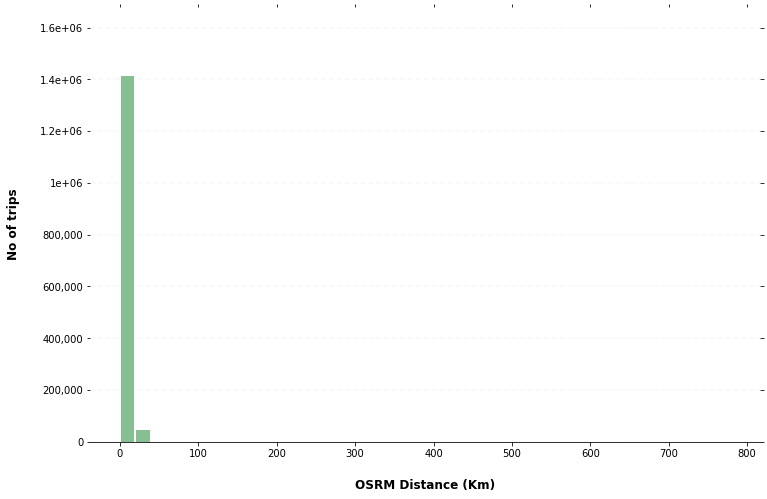

In [40]:
ax = df.hist(column='osrm_distance', bins=40, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("OSRM Distance (Km)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("No of trips", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

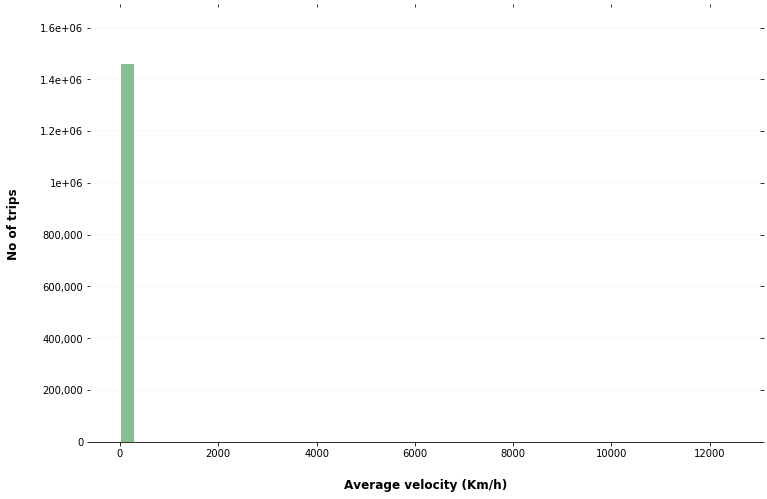

In [41]:
ax = df.hist(column='average_velocity', bins=40, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Average velocity (Km/h)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("No of trips", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Data Cleaning

In [52]:
cleaned_df = transformed_df[((transformed_df['average_velocity'] < 50) & (transformed_df['average_velocity'] > 5))]

(cleaned_df.shape[0]/transformed_df.shape[0])*100

96.2346859724536

In [51]:
cleaned_df = transformed_df[((transformed_df['osrm_distance'] < 15) & (transformed_df['osrm_distance'] > 0))]

(cleaned_df.shape[0]/transformed_df.shape[0])*100

94.36875698429348

In [ ]:
0-15km


In [53]:
cleaned_df = transformed_df[((transformed_df['average_velocity'] < 50) & (transformed_df['average_velocity'] > 5))
                           & ((transformed_df['osrm_distance'] < 15) & (transformed_df['osrm_distance'] > 0))]

In [54]:
df = cleaned_df

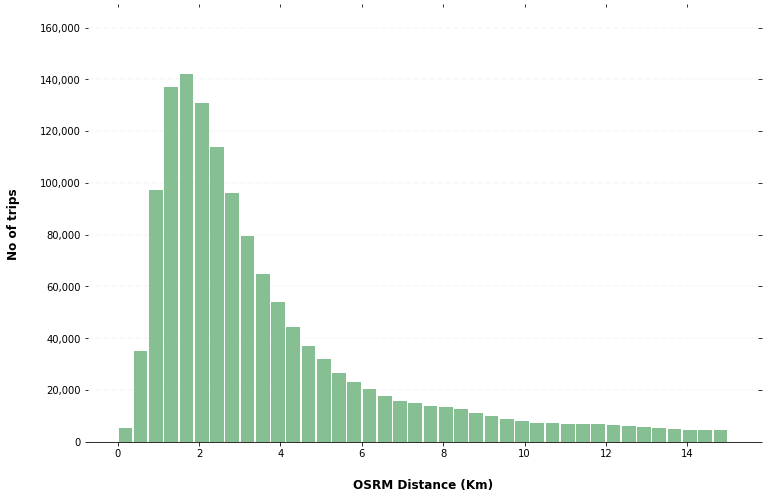

In [55]:
ax = df.hist(column='osrm_distance', bins=40, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("OSRM Distance (Km)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("No of trips", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

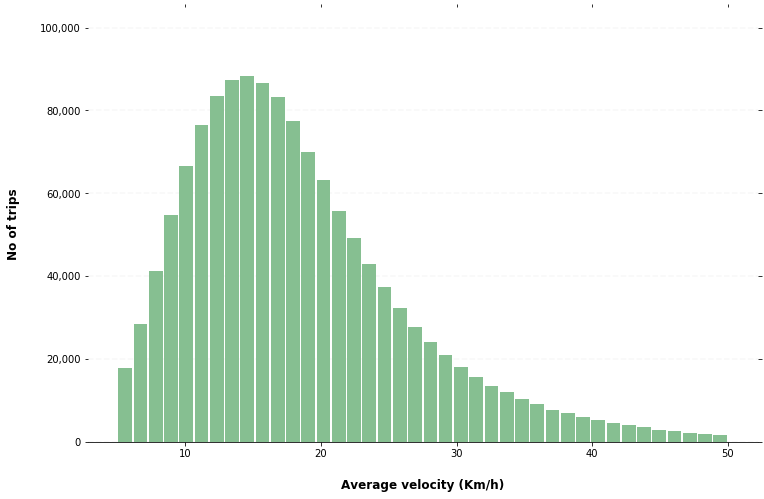

In [56]:
ax = df.hist(column='average_velocity', bins=40, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Average velocity (Km/h)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("No of trips", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [57]:
print("Removed row count: ",transformed_df.shape[0]-cleaned_df.shape[0])

Removed row count:  116316


In [58]:
cleaned_df.max(axis=0)

id                          id3999999
passenger_count                     6
store_and_fwd_flag                  Y
pickup_day_of_week                  6
pickup_hour                        23
pickup_minute                      59
pick_hex_id           882a10c687fffff
drop_hex_id           882a10c687fffff
pick_hex_centr_lat            41.1583
pick_hex_centr_lon           -73.3319
drop_hex_centr_lat            41.0958
drop_hex_centr_lon           -73.3319
osrm_distance                 14.9999
osrm_duration                  1553.3
trip_duration                    8550
average_velocity              49.9989
dtype: object

In [13]:
plt.scatter(cleaned_df.osrm_distance, cleaned_df.trip_duration, s=0.01, c="blue", alpha=0.5)

NameError: name 'plt' is not defined

### Making Train Dataset

In [59]:
 X, y = cleaned_df.iloc[:,~cleaned_df.columns.isin(["id",'passenger_count','store_and_fwd_flag','pickup_minute','pick_hex_id','drop_hex_id','osrm_duration','average_velocity','trip_duration'])],cleaned_df["trip_duration"]

In [60]:
X.head()

,pickup_day_of_week,pickup_hour,pick_hex_centr_lat,pick_hex_centr_lon,drop_hex_centr_lat,drop_hex_centr_lon,osrm_distance
0,0,17,40.771055,-73.986556,40.766348,-73.964962,2.0097
1,6,0,40.739591,-73.976764,40.730917,-74.004238,2.5131
2,1,11,40.763188,-73.984107,40.709680,-74.007674,11.0605
3,2,19,40.717542,-74.010125,40.704168,-74.016008,1.7794
4,5,13,40.789953,-73.972303,40.782084,-73.969855,1.6151


In [61]:
y.head()

0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64

## Model Training

In [62]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [63]:
X = np.array(X)
y = np.array(y)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [65]:
print("train set size: ",X_train.size)
print("test set size: ",X_test.size)

train set size:  7516957
test set size:  1879241


In [66]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Get Prediction

In [67]:
y_pred = regressor.predict(X_test)

In [68]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()

,Actual,Predicted
0,423,543.823789
1,1479,991.639746
2,931,525.604811
3,413,456.477621
4,404,656.394804


## Check Model Accuracy

In [69]:
print('Mean Absolute Error(s):', metrics.mean_absolute_error(y_test, y_pred))   
print('Root Mean Squared Error(s):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error(s): 230.7701786927378
Root Mean Squared Error(s): 325.5104945162592


## Benchmark Test

In [70]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [71]:
def test_set_predict(model,test_df):

    x_test, y_test = test_df.iloc[:,~test_df.columns.isin(["id",'passenger_count','store_and_fwd_flag','pickup_minute','pick_hex_id','drop_hex_id','osrm_duration','average_velocity','trip_duration'])],test_df["trip_duration"]
    
    preds = model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))

    mae=mean_absolute_error(y_test,preds)


    rmse1 = np.sqrt(mean_squared_error(y_test,test_df[['osrm_duration']]))
    mae1 = mean_absolute_error(y_test,test_df[['osrm_duration']])


    print("RMSE of Linear_reg: %f" % (rmse))
    print("RMSE of OSRM: %f" % (rmse1))

    print("MAE of Linear_reg: %f" % (mae))
    print("MAE of OSRM: %f" % (mae1))

    return rmse,mae,rmse1,mae1

In [72]:
test_set_predict(regressor, cleaned_df)

RMSE of Linear_reg: 325.443244
RMSE of OSRM: 539.017409
MAE of Linear_reg: 230.625486
MAE of OSRM: 402.138877


(325.4432442468788, 230.625486017168, 539.0174090372611, 402.1388766711812)

In [78]:
import matplotlib.pyplot as plt
import numpy as np


def do_benchmark_with_osrm(model,test_df):

    linear_reg_mae_array=[]
    osrm_mae_array=[]
    count_array=[]

    for i in range(1,16):
        try:

            test_df_temp = test_df.drop(test_df[((test_df['osrm_distance'])>1*i) | ((test_df['osrm_distance'])<=(1*i-1))].index)
            print("Distance between {}-{}".format((1*i-1),1*i))
            print(len(test_df_temp.index))

            count_array.append(len(test_df_temp.index))

            rmse,mae,rmse1,mae1 = test_set_predict(model,test_df_temp)

            linear_reg_mae_array.append(mae)
            osrm_mae_array.append(mae1)

        except:

            pass


    distance = np.arange(0,15,1)

#     plt.plot(distance, linear_reg_mae_array, color='r', label='Linear reg')
    plt.plot(distance, linear_reg_mae_array, color='r', label='Gradient Boosting')
    plt.plot(distance, osrm_mae_array, color='b', label='OSRM')

    plt.ylabel('Mean Absolute Error(s)')
    plt.xlabel('Distance (km)')
    plt.title('Mean Absolute Error variation along with distances')

    plt.legend()
    plt.show()
    print("plot success")

Distance between 0-1
98486
RMSE of Linear_reg: 184.226667
RMSE of OSRM: 164.751324
MAE of Linear_reg: 164.010588
MAE of OSRM: 127.951930
Distance between 1-2
362250
RMSE of Linear_reg: 191.302870
RMSE of OSRM: 301.631733
MAE of Linear_reg: 156.684643
MAE of OSRM: 239.419514
Distance between 2-3
296001
RMSE of Linear_reg: 258.276488
RMSE of OSRM: 444.662708
MAE of Linear_reg: 190.893919
MAE of OSRM: 360.830073
Distance between 3-4
181245
RMSE of Linear_reg: 324.972058
RMSE of OSRM: 549.008855
MAE of Linear_reg: 233.329708
MAE of OSRM: 450.041801
Distance between 4-5
109708
RMSE of Linear_reg: 379.789094
RMSE of OSRM: 629.510137
MAE of Linear_reg: 271.193103
MAE of OSRM: 516.306408
Distance between 5-6
70375
RMSE of Linear_reg: 414.022978
RMSE of OSRM: 687.996104
MAE of Linear_reg: 299.007547
MAE of OSRM: 565.236578
Distance between 6-7
48964
RMSE of Linear_reg: 427.066099
RMSE of OSRM: 727.520804
MAE of Linear_reg: 312.806772
MAE of OSRM: 599.625668
Distance between 7-8
38617
RMSE of Li

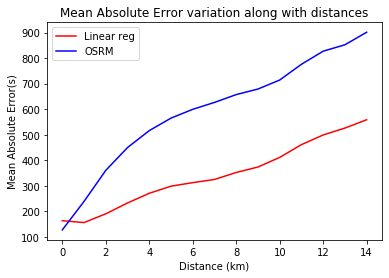

plot success


In [75]:
do_benchmark_with_osrm(regressor, cleaned_df)

##  Gradient Boosting Regressor

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd


In [77]:
gbregressor = GradientBoostingRegressor(
    max_depth=4,
    n_estimators=50,
    learning_rate=0.3
)
gbregressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Get prediction

In [79]:
y_pred = gbregressor.predict(X_test)

In [80]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()

,Actual,Predicted
0,423,556.632922
1,1479,886.912260
2,931,644.949544
3,413,376.770538
4,404,659.208196


## Check model accuracy

In [81]:
print('Mean Absolute Error(s):', metrics.mean_absolute_error(y_test, y_pred))   
print('Root Mean Squared Error(s):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error(s): 175.14603040939716
Root Mean Squared Error(s): 257.80238012672504


In [82]:
test_set_predict(gbregressor, cleaned_df)

RMSE of Linear_reg: 257.496297
RMSE of OSRM: 539.017409
MAE of Linear_reg: 175.087019
MAE of OSRM: 402.138877


(257.49629734161425, 175.0870194775338, 539.0174090372611, 402.1388766711812)

## Benchmark results

Distance between 0-1
98486
RMSE of Linear_reg: 101.347560
RMSE of OSRM: 164.751324
MAE of Linear_reg: 78.901302
MAE of OSRM: 127.951930
Distance between 1-2
362250
RMSE of Linear_reg: 154.377597
RMSE of OSRM: 301.631733
MAE of Linear_reg: 115.787519
MAE of OSRM: 239.419514
Distance between 2-3
296001
RMSE of Linear_reg: 213.366348
RMSE of OSRM: 444.662708
MAE of Linear_reg: 158.052433
MAE of OSRM: 360.830073
Distance between 3-4
181245
RMSE of Linear_reg: 254.876279
RMSE of OSRM: 549.008855
MAE of Linear_reg: 186.881647
MAE of OSRM: 450.041801
Distance between 4-5
109708
RMSE of Linear_reg: 294.500996
RMSE of OSRM: 629.510137
MAE of Linear_reg: 214.256179
MAE of OSRM: 516.306408
Distance between 5-6
70375
RMSE of Linear_reg: 323.056141
RMSE of OSRM: 687.996104
MAE of Linear_reg: 234.745502
MAE of OSRM: 565.236578
Distance between 6-7
48964
RMSE of Linear_reg: 346.168622
RMSE of OSRM: 727.520804
MAE of Linear_reg: 250.094192
MAE of OSRM: 599.625668
Distance between 7-8
38617
RMSE of Lin

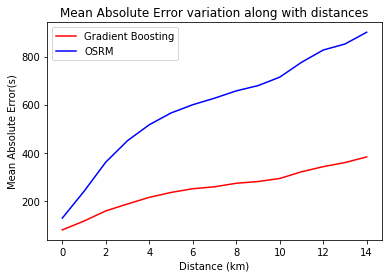

plot success


In [83]:
do_benchmark_with_osrm(gbregressor, cleaned_df)